In [1]:
import matplotlib.pyplot as plt

## Smoothing

### Introduction
The performance of the Kalman filter is not optimal when you consider future data.         
For example, suppose we are tracking an aircraft, and the latest measurement deviates far from the current track, like so (I'll only consider 1 dimension for simplicity):

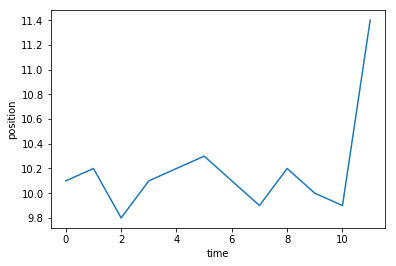

In [2]:
data = [10.1, 10.2, 9.8, 10.1, 10.2, 10.3, 
        10.1, 9.9, 10.2, 10.0, 9.9, 11.4]
plt.plot(data)
plt.xlabel('time')
plt.ylabel('position');

After a period of near steady state, we have a very large change. Assume the change is past the limit of the aircraft's flight envelope. Nonetheless the Kalman filter incorporates that new measurement into the filter based on the current Kalman gain. It cannot reject the noise because the measurement could reflect the initiation of a turn. Granted it is unlikely that we are turning so abruptly, but it is impossible to say whether
* The aircraft started a turn awhile ago, but the previous measurements were noisy and didn't show the change.
* The aircraft is turning, and this measurement is very noisy
* The measurement is very noisy and the aircraft has not turned
* The aircraft is turning in the opposite direction, and the measurement is extremely noisy

Now, suppose the following measurements are:

11.3 12.1 13.3 13.9 14.5 15.2

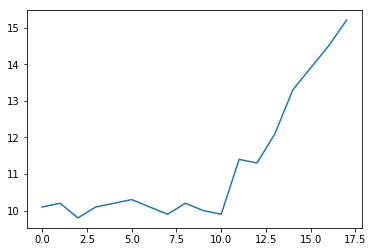

In [3]:
data2 = [11.3, 12.1, 13.3, 13.9, 14.5, 15.2]
plt.plot(data + data2);

Given these future measurements we can infer that yes, the aircraft initiated a turn.

On the other hand, suppose these are the following measurements.

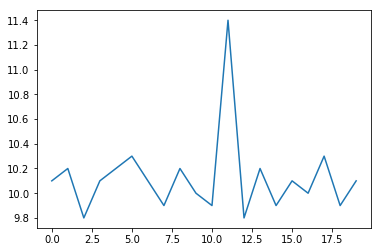

In [4]:
data3 = [9.8, 10.2, 9.9, 10.1, 10.0, 10.3, 9.9, 10.1]
plt.plot(data + data3);

In this case we are led to conclude that the aircraft did not turn and that the outlying measurement was merely very noisy.

## An Overview of How Smoothers Work
The Kalman filter is a recursive filter with the Markov property - it's estimate at step k is based only on the estimate from step k-1 and the measurement at step k. But this means that the estimate from step k-1 is based on step k-2, and so on back to the first epoch. Hence, the estimate at step k depends on all of the previous measurements, though to varying degrees. k-1 has the most influence, k-2 has the next most, and so on.

Smoothing filters incorporate future measurements into the estimate for step k. The measurement from k+1 will have the most effect, k+2 will have less effect, k+3 less yet, and so on.

This topic is called **smoothing**, but I think that is a misleading name. I could smooth the data above by passing it through a low pass filter. The result would be smooth, but not necessarily accurate because a low pass filter will remove real variations just as much as it removes noise. In contrast, Kalman smoothers are **optimal** - they incorporate all available information to make the best estimate that is mathematically achievable.

## Types of Smoothers
There are three classes of Kalman smoothers that produce better tracking in these situations.

* **Fixed-Interval Smoothing**

This is a batch processing based filter. This filter waits for all of the data to be collected before making any estimates. For example, you may be a scientist collecting data for an experiment, and don't need to know the result until the experiment is complete. A fixed-interval smoother will collect all the data, then estimate the state at each measurement using all available previous and future measurements. If it is possible for you to run your Kalman filter in batch mode it is always recommended to use one of these filters a it will provide much better results than the recursive forms of the filter from the previous chapters.

* **Fixed-Lag Smoothing**

Fixed-lag smoothers introduce latency into the output. Suppose we choose a lag of 4 steps. The filter will ingest the first 3 measurements but not output a filtered result. Then, when the 4th measurement comes in the filter will produce the output for measurement 1, taking measurements 1 through 4 into account. When the 5th measurement comes in, the filter will produce the result for measurement 2, taking measurements 2 through 5 into account. This is useful when you need recent data but can afford a bit of lag. For example, perhaps you are using machine vision to monitor a manufacturing process. If you can afford a few seconds delay in the estimate a fixed-lag smoother will allow you to produce very accurate and smooth results.

* **Fixed-Point Smoothing**

A fixed-point filter operates as a normal Kalman filter, but also produces an estimate for the state at some fixed time $j$. Before the time $k$ reaches $j$ the filter operates as a normal filter. Once $k \gt j$ the filter estimates $x_k$ and then also updates its estimate for $x_j$ using all of the measurements between $j\dots k$. This can be **useful to estimate initial paramters** for a system, or for producing the best estimate for an event that happened at a specific time. For example, you may have a robot that took a photograph at time $j$. You can use a fixed-point smoother to get the best possible pose information for the camera at time $j$ as the robot continues moving.

## Choice of Filters
The choice of these filters depends on your needs and how much memory and processing time you can spare. Fixed-point smoothing requires storage of all measurements, and is very costly to compute because the output is for every time step is recomputed for every measurement. On the other hand, the filter does produce a decent output for the current measurement, so this filter can be used for real time applications.

Fixed-lag smoothing only requires you to store a window of data, and processing requirements are modest because only that window is processed for each new measurement. The drawback is that the filter's output always lags the input, and the smoothing is not as pronounced as is possible with fixed-interval smoothing.

Fixed-interval smoothing produces the most smoothed output at the cost of having to be batch processed. Most algorithms use some sort of forwards/backwards algorithm that is only twice as slow as a recursive Kalman filter.